In [1]:
%run stdPackages.ipynb

# Social Security Design - Argentina

## 1. Data and settings

In [2]:
t0date = 2010
ngrid = 25
ns0 = 50
t_ss  = 5 # number of periods in steady state
%run ArgentinaData.ipynb

## 2. LOG model:

In [3]:
m.db.update(m.adjPar('ρ',1))
calsLOG = m.calibLOG()
pathLOG, solsLOG = m.solvePEE()

## 3. CRRA:

In [ ]:
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

 Start by broadcasting LOG solution CRRA state space:

In [ ]:
m.PEE.interpInitialsFromLOG(solsLOG, pathLOG)
m.PEE.kwargs_t['x0_from_solp'] = False # Use x0 instead of solp when iterating over time
m.PEE.kwargsMain = m.PEE.defaultKwargs

Iterate through grid:

In [6]:
ρGrid = np.array([1.1, 1.2, 1.8])
cals, paths, sols = auxFunctions.calibrateOnGrid(m, ρGrid, 'ρ')

This loops through different parameter values for $\rho$, calibrates the model, stores the dictionary of policy functions for each $t$, stores main calibration parameters, and the solution path. We start from the LOG model.

In [2]:
ρLower = np.round(np.linspace(0.75, 1, 21), 3) # we need more dense grid when we lower ρ 
ρUpper = np.round(np.linspace(1, 2, 11), 3)
# ρgrid = np.array([1, 1.1])
ρgrid = np.hstack([ρLower, ρUpper[1:]])
sols = dict.fromkeys(ρgrid)
cals = dict.fromkeys(ρgrid)
paths = dict.fromkeys(ρgrid)

## 2. LOG model

Calibrate, solve policy functions, identify PEE paths:

In [4]:
m.db.update(m.adjPar('ρ', 1))
cals[1] = m.calibLOG()
paths[1], sols[1] = m.solvePEE()

## 3. CRRA model

To calibrate the CRRA model, we proceed as follows:
1. Start from the log model and iterate over gradually larger $\rho$-values. Reset to log and iterate the other direction.
2. Use combinations that are solves to form approximation over $\rho$ (for parameters + policy function solution). Retry all combinations with this updating scheme.
3. Run step 2. until all combinations are solved or a max iteration is reached.

### 3.1. Initial solution step

Ignore ```RunTimeWarning``` in the following:

In [5]:
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

 Start by broadcasting LOG solution CRRA state space:

In [6]:
m.PEE.interpInitialsFromLOG(sols[1], paths[1])
m.PEE.kwargs_t['x0_from_solp'] = False # Use x0 instead of solp when iterating over time
m.PEE.kwargsMain = m.PEE.defaultKwargs

Loop through $\rho$:

In [7]:
def simpleρIte(ρgrid):
    for ρ in ρgrid:
        try:
            m.db.update(m.adjPar('ρ',ρ))
            cals[ρ] = m.calibPEE()
            paths[ρ], sols[ρ] = m.solvePEE()
            # sols[ρ] = m.PEE.FH()
            # paths[ρ] = m.EE_FH_CRRA_solve(sols[ρ])
        except AssertionError:
            cals[ρ] = """Failed to calibrate"""
        print(ρ)

Apply:

In [11]:
simpleρIte(ρgrid[ρgrid>1]) # solve for ρ > 1
m.calibUpdateParameters(cals[1]) # reset to log
m.PEE.interpInitialsFromLOG(sols[1], paths[1]) # reset to log
simpleρIte(ρgrid[ρgrid<1][::-1]) # solve for ρ < 1

Retry using interpolant (with extrapolation) as initial values:

In [10]:
def ρApproxInitials(cals, sols):
    # Approximation of calibration parameters:
    fp = np.vstack([v for k,v in cals.items() if isinstance(v, np.ndarray)])
    xp = np.array([k for k,v in cals.items() if isinstance(v, np.ndarray)])
    x  = np.array([k for k,v in cals.items() if not isinstance(v, np.ndarray)])
    cals2d =  scipy.interpolate.PchipInterpolator(xp, fp, extrapolate = True)(x)
    cals_x0 = {x[i]: cals2d[i,:] for i in range(len(x))}
    # Get approximation for initial values:
    xp = xp[xp != 1]
    sols_x0 = dict.fromkeys(x)
    [sols_x0.__setitem__(xi, {}) for xi in x];
    for t in m.db['txE']:
        fp = np.vstack([sols[xi][t]['x_unbounded'] for xi in xp])
        x0 = scipy.interpolate.PchipInterpolator(xp, fp, extrapolate = True)(x)
        [sols_x0[x[i]].__setitem__(t, x0[i,:]) for i in range(len(x))];
    t = m.db['t'][-1]
    fp = np.vstack([sols[xi][t]['τ_unbounded'] for xi in xp])
    x0 = scipy.interpolate.PchipInterpolator(xp, fp, extrapolate = True)(x)
    [sols_x0[x[i]].__setitem__(t, x0[i,:]) for i in range(len(x))];
    return x, cals_x0, sols_x0
def ρIte(x, cals_x0, sols_x0):
    for ρ in x:
        try:
            m.db.update(m.adjPar('ρ',ρ))
            m.calibUpdateParameters(cals_x0[ρ])
            m.PEE.x0 = sols_x0[ρ]
            cals[ρ] = m.calibPEE()
            sols[ρ] = m.PEE.FH()
            paths[ρ] = m.EE_FH_PEE_solve(sols[ρ])
        except AssertionError:
            cals[ρ] = """Failed to calibrate"""
        print(ρ)

Try to update and see if we get anywhere:

In [11]:
x, cals_x0, sols_x0 = ρApproxInitials(cals, sols)
ρIte(x, cals_x0, sols_x0)

0.75
0.762
0.775
0.788
0.8
0.812
0.825
0.838
0.85
0.862
0.875
0.912


For some reason, one of these seems to solve for the wrong policy in the baseline year:

In [13]:
d = {k: v['τ'].xs(2)-0.142 for k,v in paths.items() if v is not None}
d = {k:v for k,v in d.items() if abs(v)>1e-4}

Remove these again:

In [14]:
[cals.__setitem__(k, 'Failed to calibrate') for k in d];

Now, try again:

In [16]:
x, cals_x0, sols_x0 = ρApproxInitials(cals, sols)
ρIte(x, cals_x0, sols_x0)

0.75
0.762
0.775
0.788
0.8
0.812
0.825
0.838


Try again:

In [18]:
d = {k: v['τ'].xs(2)-0.142 for k,v in paths.items() if v is not None}
d = {k:v for k,v in d.items() if abs(v)>1e-4}
[cals.__setitem__(k, 'Failed to calibrate') for k in d];

Try again:

In [19]:
x, cals_x0, sols_x0 = ρApproxInitials(cals, sols)
ρIte(x, cals_x0, sols_x0)

0.75
0.762
0.775
0.788
0.8
0.812
0.825


AGAIN:

In [65]:
d = {k: v['τ'].xs(2)-0.142 for k,v in paths.items() if v is not None}
d = {k:v for k,v in d.items() if abs(v)>1e-4}
[cals.__setitem__(k, 'Failed to calibrate') for k in d];

And again:

In [75]:
x, cals_x0, sols_x0 = ρApproxInitials(cals, sols)
ρIte(x, cals_x0, sols_x0)

0.75


Store this:

In [85]:
with open(os.path.join(d['data'], 'Argentina_cals'), "wb") as file:
    pickle.dump(cals, file)
with open(os.path.join(d['data'], 'Argentina_sols'), "wb") as file:
    pickle.dump(sols, file)
with open(os.path.join(d['data'], 'Argentina_paths'), "wb") as file:
    pickle.dump(paths, file)

## 4. Adjusting parameters to reflect pension reform

The unexpected changes arrive in 2010. The easiest way to introduce this is to initialize a new model that runs from 2010:

In [9]:
t0 = 2
plotDates = dates[t0:-2]
m2010 = m.createCopyFromt0(t0) # create copy of model instance that slices time from t = 2

We note that $\theta, \epsilon$ varies across different calibrations. To start with, solve everything on a common grid of $\epsilon$ values. To each iteration, add specific values (baseline + universal coverage + 1-theta):

In [10]:
ϵgrid = np.round(np.linspace(.1, .2, 6), 3)
simPols  = dict.fromkeys(zip(ρgrid, ϵgrid))
simPaths = dict.fromkeys(zip(ρgrid, ϵgrid))
ϵTargs = dict.fromkeys(ρgrid)

Start from LOG-solution again:

In [11]:
ρ = 1
m2010.db.update(m2010.adjPar('ρ',ρ))
m2010.calibUpdateParameters(cals[ρ])
ϵTargs[ρ] = [m2010.db['eps'].xs(t0), m2010.getEps(coverageRate = 1), 1-m2010.db['θ'].xs(t0)]
ϵgrid_ρ = np.insert(ϵgrid, np.searchsorted(ϵgrid, ϵTargs[ρ]), ϵTargs[ρ])
for ϵ in ϵgrid_ρ:
    m2010.db.update(m2010.adjPar('eps', ϵ)) # permanent changes in epsilon
    simPols[(ρ,ϵ)]  = m2010.LOG.FH()
    simPaths[(ρ,ϵ)] = m2010.EE_FH_LOG_solve(simPols[(ρ, ϵ)], z0 = [paths[ρ]['s[t-1]'][t0], paths[ρ]['s0/s[t-1]'][t0]])

Now, loop through different $\rho$ values:

In [12]:
for ρ in ρgrid[ρgrid>1]:
    m2010.db.update(m2010.adjPar('ρ',ρ))
    m2010.calibUpdateParameters(cals[ρ])
    ϵTargs[ρ] = [m2010.db['eps'].xs(t0), m2010.getEps(coverageRate = 1), 1-m2010.db['θ'].xs(t0)]
    ϵgrid_ρ = np.insert(ϵgrid, np.searchsorted(ϵgrid, ϵTargs[ρ]), ϵTargs[ρ])
    m2010.PEE.x0 = {t: sols[ρ][t]['x_unbounded'] for t in m2010.db['t']}
    m2010.PEE.x0[m2010.db['t'][-1]] = sols[ρ][m2010.db['t'][-1]]['τ_unbounded']
    m2010.x0['EE_FH_PEE'] = np.hstack([adj.rc_pd(paths[ρ][k], m2010.db['t']).values for k in m2010.ns['EE_FH_PEE'].symbols])
    for ϵ in ϵgrid_ρ[ϵgrid_ρ>=ϵTargs[ρ][0]]:
        m2010.db.update(m2010.adjPar('eps',ϵ))
        simPols[(ρ,ϵ)] = m2010.PEE.FH()
        simPaths[(ρ,ϵ)] = m2010.EE_FH_PEE_solve(simPols[(ρ,ϵ)], z0 = [paths[ρ]['s[t-1]'][t0], paths[ρ]['s0/s[t-1]'][t0]])
        print((ρ, ϵ))

(np.float64(1.1), np.float64(0.056767854214377036))
(np.float64(1.1), np.float64(0.0810969345919672))
(np.float64(1.1), np.float64(0.1))
(np.float64(1.1), np.float64(0.12))
(np.float64(1.1), np.float64(0.14))
(np.float64(1.1), np.float64(0.16))
(np.float64(1.1), np.float64(0.16093572527544364))
(np.float64(1.1), np.float64(0.18))
(np.float64(1.1), np.float64(0.2))
(np.float64(1.2), np.float64(0.05585358326824887))
(np.float64(1.2), np.float64(0.07979083324035553))
(np.float64(1.2), np.float64(0.1))
(np.float64(1.2), np.float64(0.12))
(np.float64(1.2), np.float64(0.14))
(np.float64(1.2), np.float64(0.16))
(np.float64(1.2), np.float64(0.16093572527544364))
(np.float64(1.2), np.float64(0.18))
(np.float64(1.2), np.float64(0.2))
(np.float64(1.3), np.float64(0.05509415693221862))
(np.float64(1.3), np.float64(0.07870593847459803))
(np.float64(1.3), np.float64(0.1))
(np.float64(1.3), np.float64(0.12))
(np.float64(1.3), np.float64(0.14))
(np.float64(1.3), np.float64(0.16))
(np.float64(1.3), np.

Now look at stuff for values lower than 1:

In [51]:
ρ = 0.9
m2010.db.update(m2010.adjPar('ρ',ρ))
m2010.calibUpdateParameters(cals[ρ])
ϵTargs[ρ] = [m2010.db['eps'].xs(t0), m2010.getEps(coverageRate = 1), 1-m2010.db['θ'].xs(t0)]
ϵgrid_ρ = np.insert(ϵgrid, np.searchsorted(ϵgrid, ϵTargs[ρ]), ϵTargs[ρ])
m2010.PEE.x0 = {t: sols[ρ][t]['x_unbounded'] for t in m2010.db['t']}
m2010.PEE.x0[m2010.db['t'][-1]] = sols[ρ][m2010.db['t'][-1]]['τ_unbounded']
m2010.x0['EE_FH_PEE'] = np.hstack([adj.rc_pd(paths[ρ][k], m2010.db['t']).values for k in m2010.ns['EE_FH_PEE'].symbols])

In [56]:
m2010.db.update(m2010.adjPar('eps',.07))
sols = m2010.PEE.FH()

KeyboardInterrupt: 

In [39]:
for ρ in ρgrid[ρgrid<1]:
    m2010.db.update(m2010.adjPar('ρ',ρ))
    m2010.calibUpdateParameters(cals[ρ])
    ϵTargs[ρ] = [m2010.db['eps'].xs(t0), m2010.getEps(coverageRate = 1), 1-m2010.db['θ'].xs(t0)]
    ϵgrid_ρ = np.insert(ϵgrid, np.searchsorted(ϵgrid, ϵTargs[ρ]), ϵTargs[ρ])
    m2010.PEE.x0 = {t: sols[ρ][t]['x_unbounded'] for t in m2010.db['t']}
    m2010.PEE.x0[m2010.db['t'][-1]] = sols[ρ][m2010.db['t'][-1]]['τ_unbounded']
    m2010.x0['EE_FH_PEE'] = np.hstack([adj.rc_pd(paths[ρ][k], m2010.db['t']).values for k in m2010.ns['EE_FH_PEE'].symbols])
    for ϵ in ϵTargs[ρ]:
        m2010.db.update(m2010.adjPar('eps',ϵ))
        simPols[(ρ,ϵ)] = m2010.PEE.FH()
        simPaths[(ρ,ϵ)] = m2010.EE_FH_PEE_solve(simPols[(ρ,ϵ)], z0 = [paths[ρ]['s[t-1]'][t0], paths[ρ]['s0/s[t-1]'][t0]])
        print((ρ, ϵ))

KeyboardInterrupt: 

Jump in tax rate as a function of $\rho$:

In [14]:
k = 'τ'
NewVals = np.array([simPaths[(ρ, ϵTargs[ρ][-1])][k].xs(t0) for ρ in ρgrid[ρgrid>=1]])
Original = np.array([simPaths[(ρ, ϵTargs[ρ][0])][k].xs(t0) for ρ in ρgrid[ρgrid>=1]])

<Axes: >

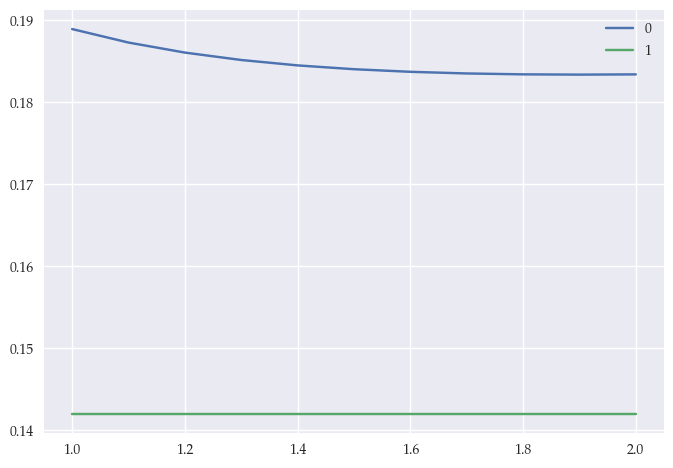

In [15]:
pd.concat([pd.Series(NewVals, index = ρgrid[ρgrid>=1]), pd.Series(Original, index = ρgrid[ρgrid>=1])], axis = 1).plot()

*1. Start run from previous solution:*

In [5]:
# with open('argentina_CRRA_x0.pkl', "rb") as file:
#     sols = pickle.load(file)
# m.PEE.x0[m.T-1] = sols[m.T-1]['τ_unbounded']
# [m.PEE.x0.__setitem__(t, sols[t]['x_unbounded']) for t in sols if t != m.T-1];

*2. Use LOG solution as initial values for the CRRA model:*

In [6]:
m.PEE.interpInitialsFromLOG(sols_LOG, path_LOG)
m.PEE.kwargs_t['x0_from_solp'] = False

*3. Start from small grid and interpolate to get "large grid" starting values:*

In [7]:
# m.PEE_initialsFromSmallGrid(10, 10);

Test solve:

In [8]:
sols_PEE = m.PEE.FH()
PEE = m.EE_FH_PEE_solveRobust(sols_PEE)

*Save as pickle:*

In [9]:
with open('argentina_CRRA_x0.pkl', "wb") as file: 
    pickle.dump(sols_PEE, file)

Calibration:

In [10]:
m.calibPEE();

C:\Users\sxj477\AppData\Local\anaconda3\envs\SSD\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\sxj477\AppData\Local\anaconda3\envs\SSD\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\sxj477\AppData\Local\anaconda3\envs\SSD\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\sxj477\AppData\Local\anaconda3\envs\SSD\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\sxj477\AppData\Local\anaconda3\envs\SSD\Lib\site-packages\scipy\optimize\_nonlin.py:374: RuntimeWarning: invalid value encountered in scalar divide
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\sxj477\AppData\L

Loop through values of $\rho$, store calibration parameters, 